# Band-edge filter construction

### References

fred harris, Multirate Signal Processing For Communications Systems, Section 13.4.2.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (7, 3.5)

## Desired filter frequency response

In [2]:
# design parameters

rolloff = 0.35  # RRC alpha
sps = 4  # samples per symbol

In [3]:
# other parameters
NFFT = 4096

In [4]:
faxis = np.fft.fftshift(np.fft.fftfreq(NFFT))

The frequency response of each of the two band edges of the band-edge filter must be a half-cosine that spans the frequency interval corresponding to the roll-off of the RRC filter. The length of this frequency interval is `rolloff/sps`. We first design this frequency response at baseband.

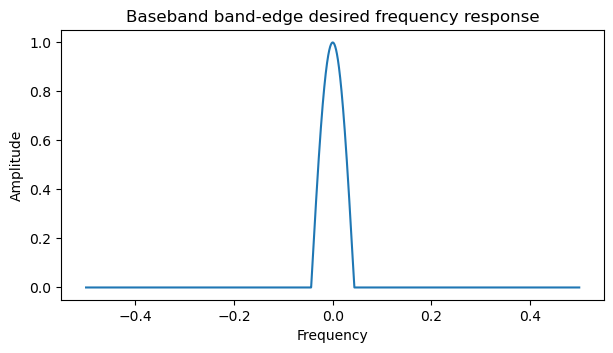

In [5]:
half_cos_pulse = np.cos(np.pi * faxis / (rolloff / sps))
half_cos_pulse[np.abs(faxis) > 0.5 * rolloff / sps] = 0
plt.plot(faxis, half_cos_pulse)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Baseband band-edge desired frequency response');

The baseband frequency response is frequency shifted to the centres of the roll-offs of the RRC filter. These are at `+/- 0.5/sps`. We now design the shifted frequency responses. We take advantage of the fact that `NFFT / (2 * sps)` is an integer for simplicity.

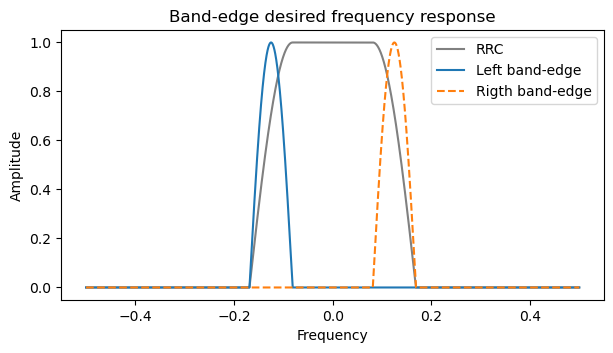

In [6]:
assert NFFT % sps == 0

rrc_response = np.zeros(NFFT)
rrc_response[np.abs(faxis) <= 0.5 * (1 - rolloff) / sps] = 1
rrc_edge_sel = (0.5 * (1 - rolloff) / sps < np.abs(faxis)) & (np.abs(faxis) < 0.5 * (1 + rolloff) / sps)
rrc_edge = np.sqrt(0.5 * (1 + np.cos(np.pi * sps / rolloff * (np.abs(faxis) - 0.5 * (1 - rolloff) / sps))))
rrc_response[rrc_edge_sel] = rrc_edge[rrc_edge_sel]

left_band_edge = np.roll(half_cos_pulse, -NFFT // (2 * sps))
right_band_edge = np.roll(half_cos_pulse, NFFT // (2 * sps))
plt.plot(faxis, rrc_response, color='grey', label='RRC')
plt.plot(faxis, left_band_edge, label='Left band-edge')
plt.plot(faxis, right_band_edge, '--', label='Rigth band-edge')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Band-edge desired frequency response')
plt.legend();

## GNU Radio implementation

The GNU Radio filter design is implemented in `fll_band_edge_cc_impl::design_filter()` in https://github.com/gnuradio/gnuradio/blob/main/gr-digital/lib/fll_band_edge_cc_impl.cc. This section follows the same notation for the variable names.

In [7]:
# design parameters
filter_size = 128

In [8]:
M = filter_size / sps
half_sps_inv = 2 / sps
i = np.arange(filter_size)
k = -M + i * half_sps_inv
position = rolloff * k
# note that sinc() in fll_band_edge_cc_impl.cc is defined in the same
# way as np.sinc(), this is sinc(x) = sin(pi * x) / (pi * x)
bb_taps = np.sinc(position - 0.5) + np.sinc(position + 0.5)
power = np.sum(bb_taps**2)

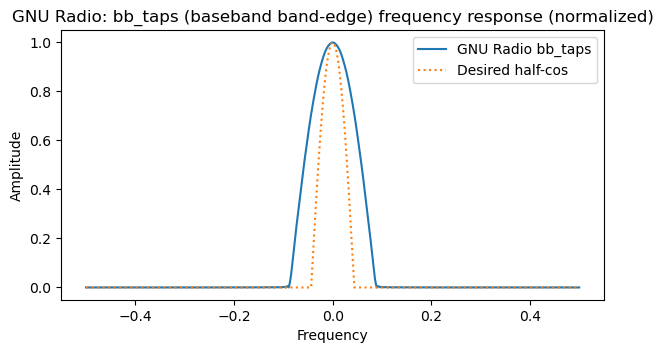

In [9]:
bb_taps_H = np.fft.fftshift(np.fft.fft(bb_taps, NFFT))
bb_taps_H /= np.max(np.abs(bb_taps_H))
plt.plot(faxis, np.abs(bb_taps_H), label='GNU Radio bb_taps')
plt.plot(faxis, half_cos_pulse, ':', label='Desired half-cos')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('GNU Radio: bb_taps (baseband band-edge) frequency response (normalized)')
plt.legend();

In [10]:
N = (filter_size - 1) // 2
invpower = 1 / power
inv_twice_sps = 0.5 / sps
k = (i - N) * inv_twice_sps
taps_lower = bb_taps * invpower * np.exp(-1j * 2 * np.pi * (1 + rolloff) * k)
taps_upper = np.conj(taps_lower)

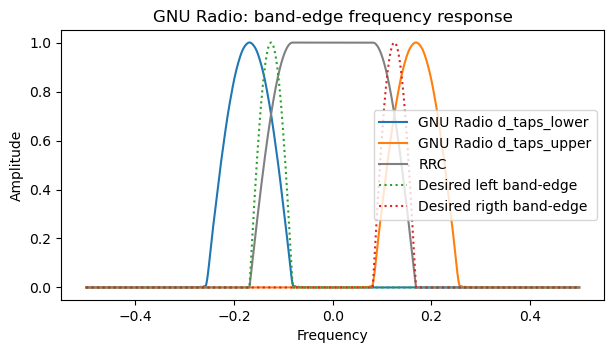

In [11]:
taps_lower_H = np.fft.fftshift(np.fft.fft(taps_lower, NFFT))
taps_upper_H = np.fft.fftshift(np.fft.fft(taps_upper, NFFT))
plt.plot(faxis, np.abs(taps_lower_H), label='GNU Radio d_taps_lower')
plt.plot(faxis, np.abs(taps_upper_H), label='GNU Radio d_taps_upper')
plt.plot(faxis, rrc_response, color='grey', label='RRC')
plt.plot(faxis, left_band_edge, ':', label='Desired left band-edge')
plt.plot(faxis, right_band_edge, ':', label='Desired rigth band-edge')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('GNU Radio: band-edge frequency response')
plt.legend();

## Fixed GNU Radio implementation

There are two bugs in the GNU Radio implementation:

- The baseband band-edge filter ends up being twice as "wide". This can be fixed by multiplying by `0.5f` in the formula for `position`.
- The baseband taps are frequency translated incorrectly. They are moved to `(1 + d_rolloff) * k`, but `k` should be used instead.

With these two fixes the filters are now correct.

In [12]:
M = filter_size / sps
half_sps_inv = 2 / sps
i = np.arange(filter_size)
k = -M + i * half_sps_inv
position = 0.5 * rolloff * k  # here we have added a 0.5 factor to fix a bug
# note that sinc() in fll_band_edge_cc_impl.cc is defined in the same
# way as np.sinc(), this is sinc(x) = sin(pi * x) / (pi * x)
bb_taps = np.sinc(position - 0.5) + np.sinc(position + 0.5)
power = np.sum(bb_taps**2)

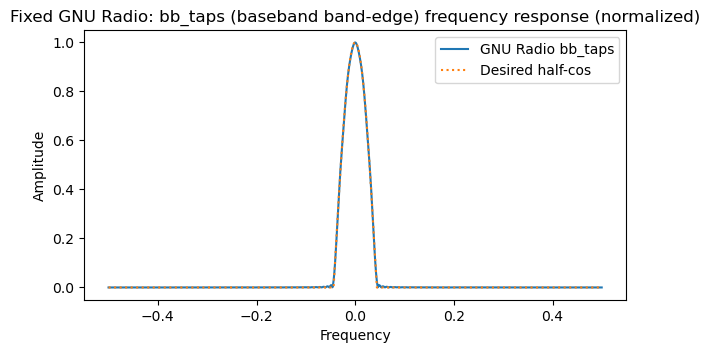

In [13]:
bb_taps_H = np.fft.fftshift(np.fft.fft(bb_taps, NFFT))
bb_taps_H /= np.max(np.abs(bb_taps_H))
plt.plot(faxis, np.abs(bb_taps_H), label='GNU Radio bb_taps')
plt.plot(faxis, half_cos_pulse, ':', label='Desired half-cos')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Fixed GNU Radio: bb_taps (baseband band-edge) frequency response (normalized)')
plt.legend();

In [14]:
N = (filter_size - 1) // 2
invpower = 1 / power
inv_twice_sps = 0.5 / sps
k = (i - N) * inv_twice_sps
# here we have removed 1 + rolloff to fix a bug
taps_lower = bb_taps * invpower * np.exp(-1j * 2 * np.pi * k)
taps_upper = np.conj(taps_lower)

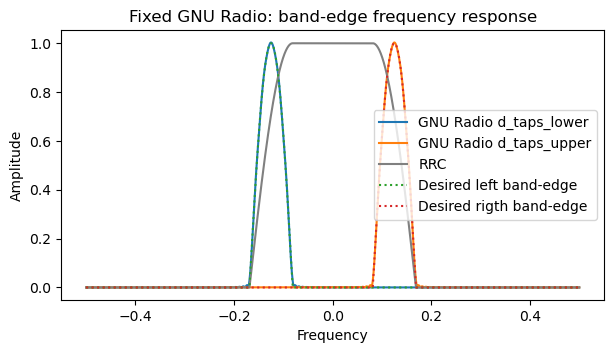

In [15]:
taps_lower_H = np.fft.fftshift(np.fft.fft(taps_lower, NFFT))
taps_upper_H = np.fft.fftshift(np.fft.fft(taps_upper, NFFT))
plt.plot(faxis, np.abs(taps_lower_H), label='GNU Radio d_taps_lower')
plt.plot(faxis, np.abs(taps_upper_H), label='GNU Radio d_taps_upper')
plt.plot(faxis, rrc_response, color='grey', label='RRC')
plt.plot(faxis, left_band_edge, ':', label='Desired left band-edge')
plt.plot(faxis, right_band_edge, ':', label='Desired rigth band-edge')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Fixed GNU Radio: band-edge frequency response')
plt.legend();